# Example of usage ImageAdaptiveThresholding and  ImageAdaptiveBinarizer transformers

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12/"

In [2]:
# install from PYPI using secret
# %pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/
ERROR: Could not find a version that satisfies the requirement spark-ocr==+spark32 (from versions: 0.0.1)
ERROR: No matching distribution found for spark-ocr==+spark32
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Initialization of spark session

In [3]:
from sparkocr import info
info()

Spark version: 3.2.1
Spark NLP version: 4.1.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.1.0



In [4]:
from pyspark.sql import SparkSession
from sparkocr import start
import sys
import os

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 4.1.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.1.0



## Import OCR transformers

In [5]:
from pyspark.ml import PipelineModel

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image

## Read PDF document as binary file

In [6]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/images/text_with_noise.png

In [7]:
image_example = "text_with_noise.png"
image_example_df = spark.read.format("binaryFile").load(image_example).cache()

## Original

In [8]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image")

ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) 


pipeline_original = PipelineModel(stages=[
    binary_to_image,
    ocr
])

#spark.sql("set spark.sql.legacy.allowUntypedScalaUDF=true")


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/text_with_noise.png
    Resolution: 95 dpi
    Width: 1095 px
    Height: 134 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


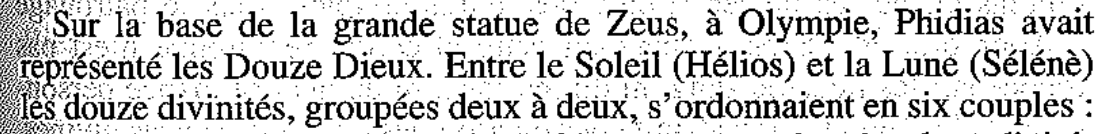

Detected text:

la base de la grande statue de Zeus, a “Olympie, Phidias avait
é les Douze Dieux. Entre le’ Soleil (HEélios) et la Lune (Séléné)
ze divinités, groupées deux a deux, s ordonnaient en six couples :
  
  


In [9]:
for r in pipeline_original.transform(image_example_df).select("image", "text").collect():
    display_image(r.image)
    print(f"Detected text:\n{r.text}")

##  Light Homogenize (LH)

In [10]:
light_homogenize = ImageHomogenizeLight() \
    .setInputCol("image") \
    .setOutputCol("image") \
    .setThreshold(0) \
    .setExpIn(112)


pipeline_lh = PipelineModel(stages=[
    binary_to_image,
    light_homogenize,
    ocr
])


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/text_with_noise.png
    Resolution: 95 dpi
    Width: 1095 px
    Height: 134 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


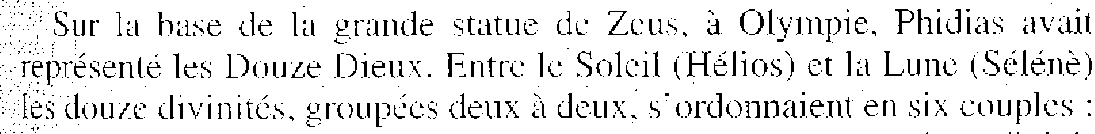

Detected text:

 
Sur la base de la grande statue de Zeus, a Olympie, Phidias avait
Teprésenté les Douze Dieux. Fntre le Soleil (Hélios) et la Lune (Seéléne)
eles douze divinités, groupées deux a deux, 5 ordonnaient en six couples :
 


In [11]:
for r in pipeline_lh.transform(image_example_df).select("image", "text").collect():
    display_image(r.image)
    print(f"Detected text:\n{r.text}")

## Contrast Enhacement (CE)

In [12]:
contrast_enhacement = ImageEnhanceContrast() \
    .setInputCol("image") \
    .setOutputCol("image") \
    .setClipLimit(4) \
    .setTileGridSize(3)

pipeline_ce = PipelineModel(stages=[
    binary_to_image,
    contrast_enhacement,
    ocr
])



    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/text_with_noise.png
    Resolution: 95 dpi
    Width: 1095 px
    Height: 134 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


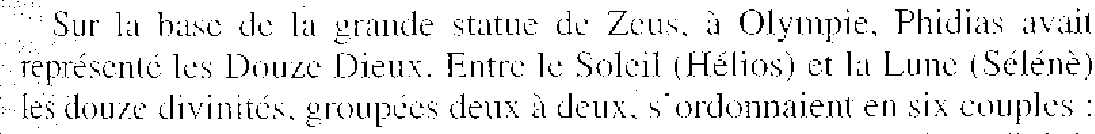

Detected text:

“Sur la hase de la grande statue de Zeus. & Olympie, Phidias avail
représenté les Douze Dieux. Entre le Soler (Hélios) et lia Lune (Séléne)
~-fes douze divinités, groupées deux A deux. s ordonnaient en six couples :


In [13]:
for r in pipeline_ce.transform(image_example_df).select("image", "text").collect():
    display_image(r.image)
    print(f"Detected text:\n{r.text}")

## Glar removing (GR)

In [14]:
glar_removing = ImageRemoveGlare() \
    .setInputCol("image") \
    .setOutputCol("image")

pipeline_gr = PipelineModel(stages=[
    binary_to_image,
    glar_removing,
    ocr
])



    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/text_with_noise.png
    Resolution: 95 dpi
    Width: 1095 px
    Height: 134 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


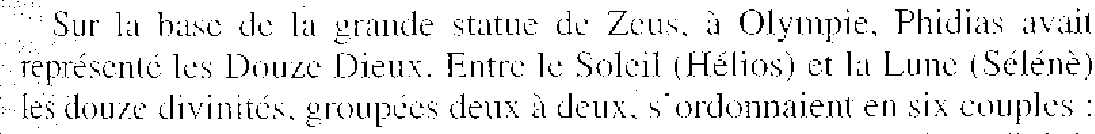

Detected text:

“Sur la hase de la grande statue de Zeus. & Olympie, Phidias avail
représenté les Douze Dieux. Entre le Soler (Hélios) et lia Lune (Séléne)
~-fes douze divinités, groupées deux A deux. s ordonnaient en six couples :


In [15]:
for r in pipeline_gr.transform(image_example_df).select("image", "text").collect():
    display_image(r.image)
    print(f"Detected text:\n{r.text}")

## Remove Background (RB)


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/text_with_noise.png
    Resolution: 95 dpi
    Width: 1095 px
    Height: 134 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


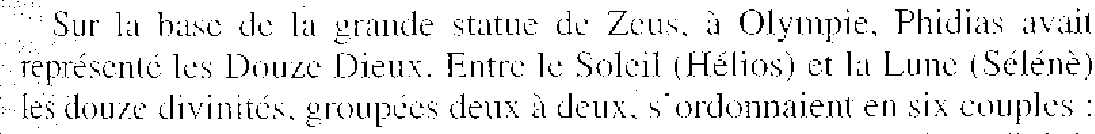

Detected text:

“Sur la hase de la grande statue de Zeus. & Olympie, Phidias avail
représenté les Douze Dieux. Entre le Soler (Hélios) et lia Lune (Séléne)
~-fes douze divinités, groupées deux A deux. s ordonnaient en six couples :


In [16]:
background_remove = ImageRemoveBackground() \
    .setInputCol("image") \
    .setOutputCol("image") \
    .setBL(260)

pipeline_rb= PipelineModel(stages=[
    binary_to_image,
    background_remove,
    ocr
])

for r in pipeline_rb.transform(image_example_df).select("image", "text").collect():
    display_image(r.image)
    print(f"Detected text:\n{r.text}")